In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [2]:
def load_data():
    datasets = ["/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat", 
                "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog"]
    
    output = []
    
    for dataset in datasets:
        images = []
        print(f"loading {dataset}")
        
        for file in tqdm(os.listdir(dataset)):
            file_path = os.path.join(dataset, file)
            
            if os.path.getsize(file_path) > 0:
                img = cv2.imread(file_path)
                
                if img is not None:
                    images.append(img)
                    
        output.append(images)
        
    return output

In [3]:
def split_data(split_size):
    datasets = load_data()
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    
    for i, dataset in enumerate(datasets):
        length = int(len(dataset)*split_size)
        
        for j, img in enumerate(dataset):
            if j < length:
                train_data.append(img)
                train_labels.append(i)
            else:
                test_data.append(img)
                test_labels.append(i)
                
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    
    return train_data, test_data, train_labels, test_labels

In [4]:
def display_random_images(color = "color", resize = "No", img_size = None):
    """
        display random five images in color or gray
    """
    fig, ax = plt.subplots(1, 5, figsize = (20, 5))
    ax = ax.ravel()   

    image_shape = set()
    for i in range(5):
        random_idx = np.random.randint(len(train_data))
        img = train_data[random_idx]

        if resize == "Yes":
            if img_size is None:
                print("Error: image size is None")
                return
            img = cv2.resize(img, img_size)
            
        if color != "color":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax[i].imshow(img, cmap = "gray")
        else:
            ax[i].imshow(img)
        image_shape.add(img.shape)
    print(image_shape)           
    plt.show()

In [5]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "train")
    plt.plot(history.history['val_accuracy'], label = "validataion")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend(loc = 'upper left')

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend(loc = 'upper left')
    plt.show()

In [6]:
split_size = 0.80
train_data, test_data, train_labels, test_labels = split_data(split_size)

loading /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat


100%|██████████| 12501/12501 [00:34<00:00, 361.72it/s]


loading /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog


100%|██████████| 12501/12501 [00:35<00:00, 351.69it/s]


In [7]:
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data, train_labels, test_size = 0.2, shuffle = True, random_state = 42) 

{(333, 500, 3), (250, 300, 3), (500, 480, 3), (375, 500, 3)}


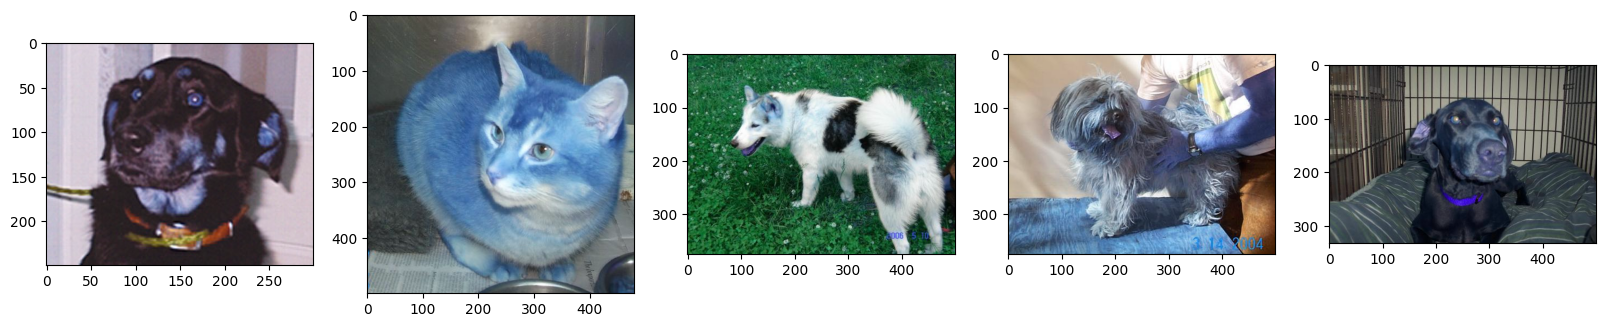

{(500, 479), (176, 168), (429, 489), (375, 500)}


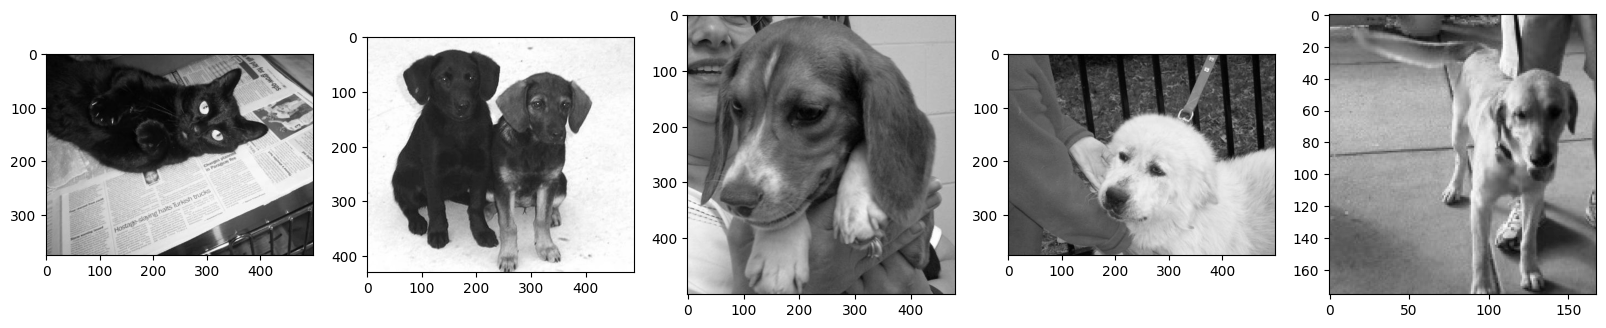

In [8]:
display_random_images("color")
display_random_images("gray")

{(150, 150)}


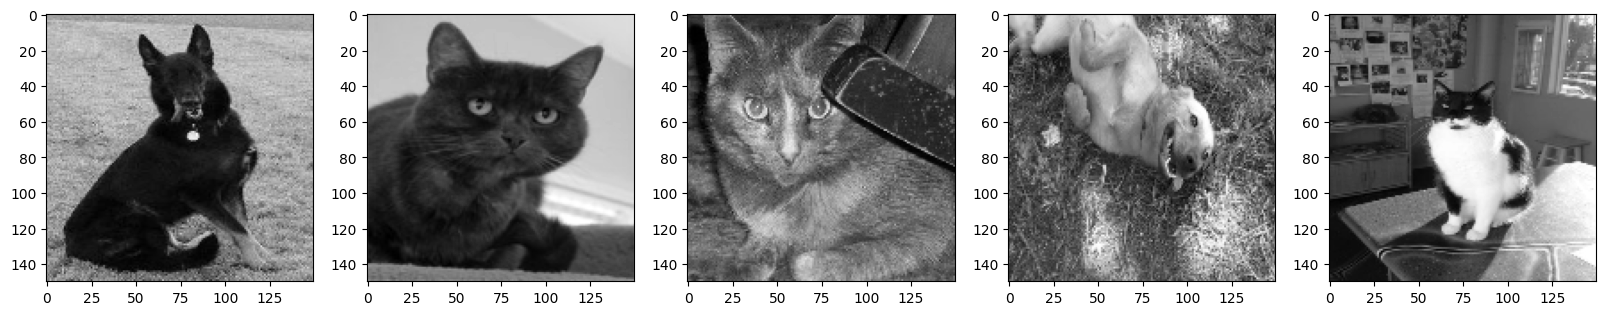

In [9]:
img_size = (150, 150)
display_random_images("gray", resize = "Yes", img_size = img_size)

In [10]:
All_images = {}

# Create a dictionary mapping variable names to actual image arrays
image_dict = {
    "train_data": train_data,
    "test_data": test_data,
    "validation_data": validation_data
}

# Loop through the dictionary
for name, images in image_dict.items():
    temp_images = []
    
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, img_size)
        img = img.reshape(img_size[1], img_size[0], 1)  # reshape to suit the CNN

        temp_images.append(img)
        
    temp_images = np.array(temp_images, dtype="float32")
    
    # Use 'name' as the key in All_images
    All_images[name] = temp_images

# Now you can check the length of the All_images dictionary
len(All_images)

3

In [11]:
batch_size = 128
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    restore_best_weights=True
)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=30,               # Randomly rotate images in the range of 0 to 30 degrees
                                   zoom_range=0.2,                  # Randomly zoom images in or out by 20%
                                   horizontal_flip=True,            # Randomly flip images horizontally
                                   brightness_range=(0.8, 1.2),     # Adjust brightness within the range of 0.8 to 1.2
                                  )

train_generator = train_datagen.flow(x=All_images["train_data"], 
                                     y=train_labels, 
                                     batch_size=batch_size, 
                                    )

validation_datagen = ImageDataGenerator(rescale = 1.0/255)

validation_generator = validation_datagen.flow(x=All_images["validation_data"], 
                                               y=validation_labels, 
                                               batch_size=batch_size, 
                                              )

2


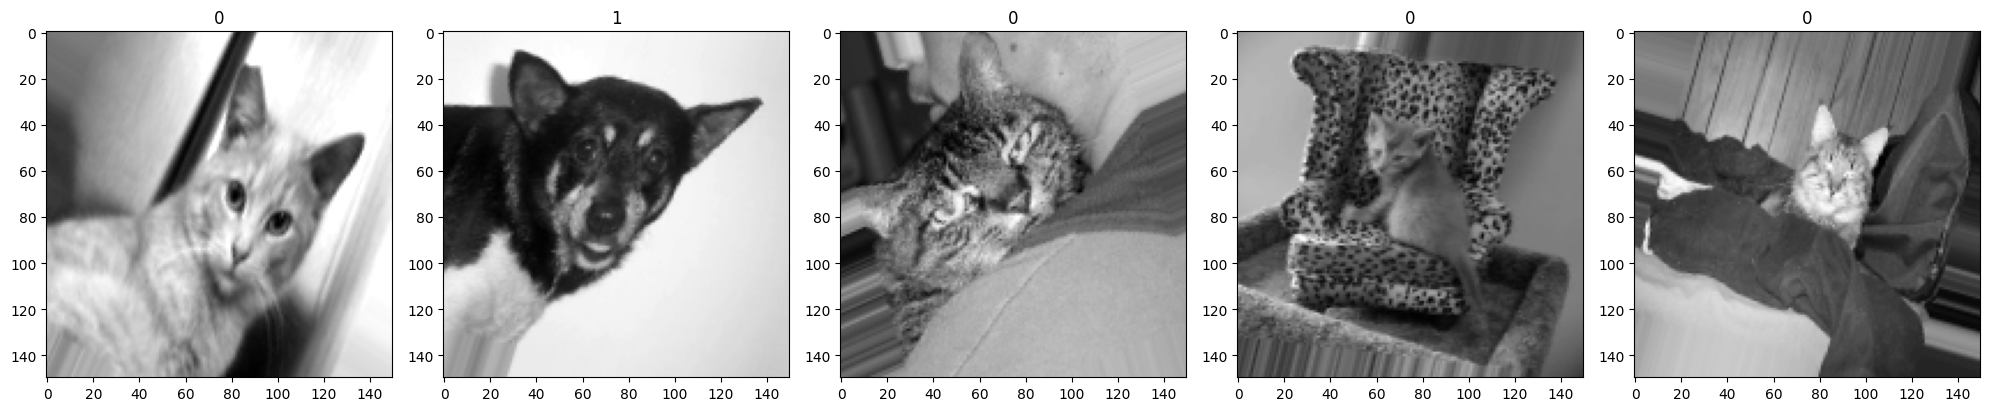

In [14]:
# Retrieve the next batch of training data and labels from the generator
train_batch = next(train_generator)  # batch contains the training_data and training_labels for batch_size = 64

# Print the length of the batch, which should indicate how many samples are included
print(len(train_batch))

# Create a figure with subplots to display images
# Create a 4x16 grid of subplots (1 rows, 5 columns), with specified figure size
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

# Flatten the 2D array of axes to easily iterate over it
ax = ax.ravel()

# Loop over the images in the batch
for i in range(5):
    # Display each image in grayscale using the corresponding axes
    ax[i].imshow(train_batch[0][i], cmap='gray')  # train_batch[0] contains the images
    # Set the title of each subplot to the corresponding label from the batch
    ax[i].set_title(train_batch[1][i])  # train_batch[1] contains the labels

# Adjust the layout of the plots for better visibility
plt.tight_layout()

# Show the figure with the displayed images
plt.show()

In [15]:
# Model definition
model = tf.keras.Sequential([
                             # First convolutional layer
                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 1)),
                             tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
                             
                             # Second convolutional layer
                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
                             
                             # Third convolution layer
                             tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"),
                             tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    
                             # Fourth convolutional layer
                             tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    
#                            # Fifth convolutional layer
#                              tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    
#                              #Fifth convolutional layer
#                              tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    
                             # Flatten the output to connect to fully connected layers
                             tf.keras.layers.Flatten(),
                             
                             # Fully connected layer
#                              tf.keras.layers.Dense(1024, activation='relu'),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(8, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification: Cat vs Dog
                           ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,686,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,818,897 (14.57 MB)

 Trainable params: 3,818,897 (14.57 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Training the model
history = model.fit(train_generator,
                    validation_data= validation_generator,
#                     steps_per_epoch=len(train_generator),
#                     validation_steps=len(validation_generator),
                    epochs = epochs,
                    callbacks=[early_stopping]
                   )

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727621221.978817     988 service.cc:145] XLA service 0x7ca914008c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727621221.978862     988 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.4863 - loss: 0.6932  

I0000 00:00:1727621227.378684     988 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 315ms/step - accuracy: 0.5052 - loss: 0.6943 - val_accuracy: 0.5243 - val_loss: 0.6885
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 282ms/step - accuracy: 0.6000 - loss: 0.6611 - val_accuracy: 0.6656 - val_loss: 0.6015
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - accuracy: 0.6798 - loss: 0.6011 - val_accuracy: 0.7192 - val_loss: 0.5490
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.7291 - loss: 0.5402 - val_accuracy: 0.7252 - val_loss: 0.5246
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - accuracy: 0.7419 - loss: 0.5167 - val_accuracy: 0.7738 - val_loss: 0.4721
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - accuracy: 0.7730 - loss: 0.4679 - val_accuracy: 0.8011 - val_loss: 0.4255
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.7862 - loss: 0.4479 - val_accuracy: 0.8201 - val_loss: 0.3986
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.8010 - loss: 0.431

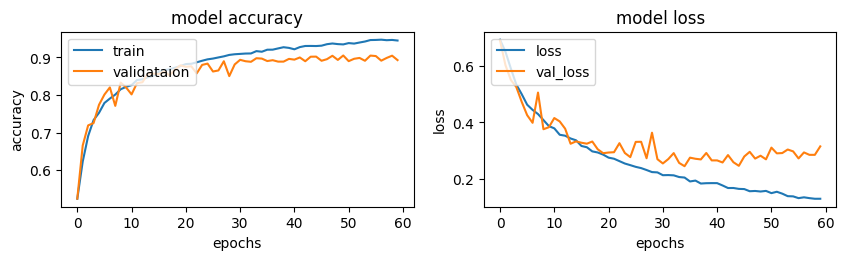

In [18]:
plot_accuracy_loss(history)

In [19]:
# Accuracy of model
model.evaluate(All_images["test_data"], test_labels)[1]

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8873 - loss: 24.2153


0.8653306365013123

In [20]:
pred_labels = model.predict(All_images["test_data"])

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [21]:
pred_labels = np.ceil(pred_labels).astype("int").tolist()

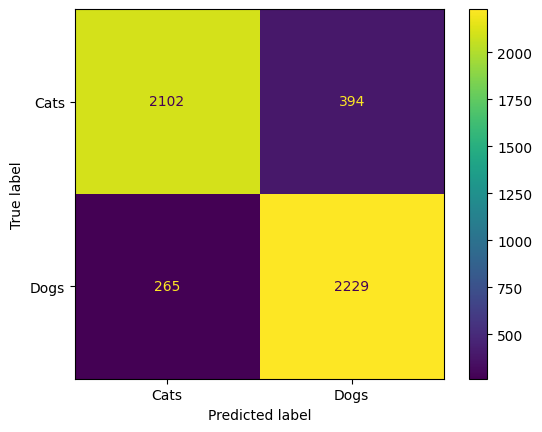

In [22]:
class_names = ["Cats", "Dogs"]
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
disp.plot()

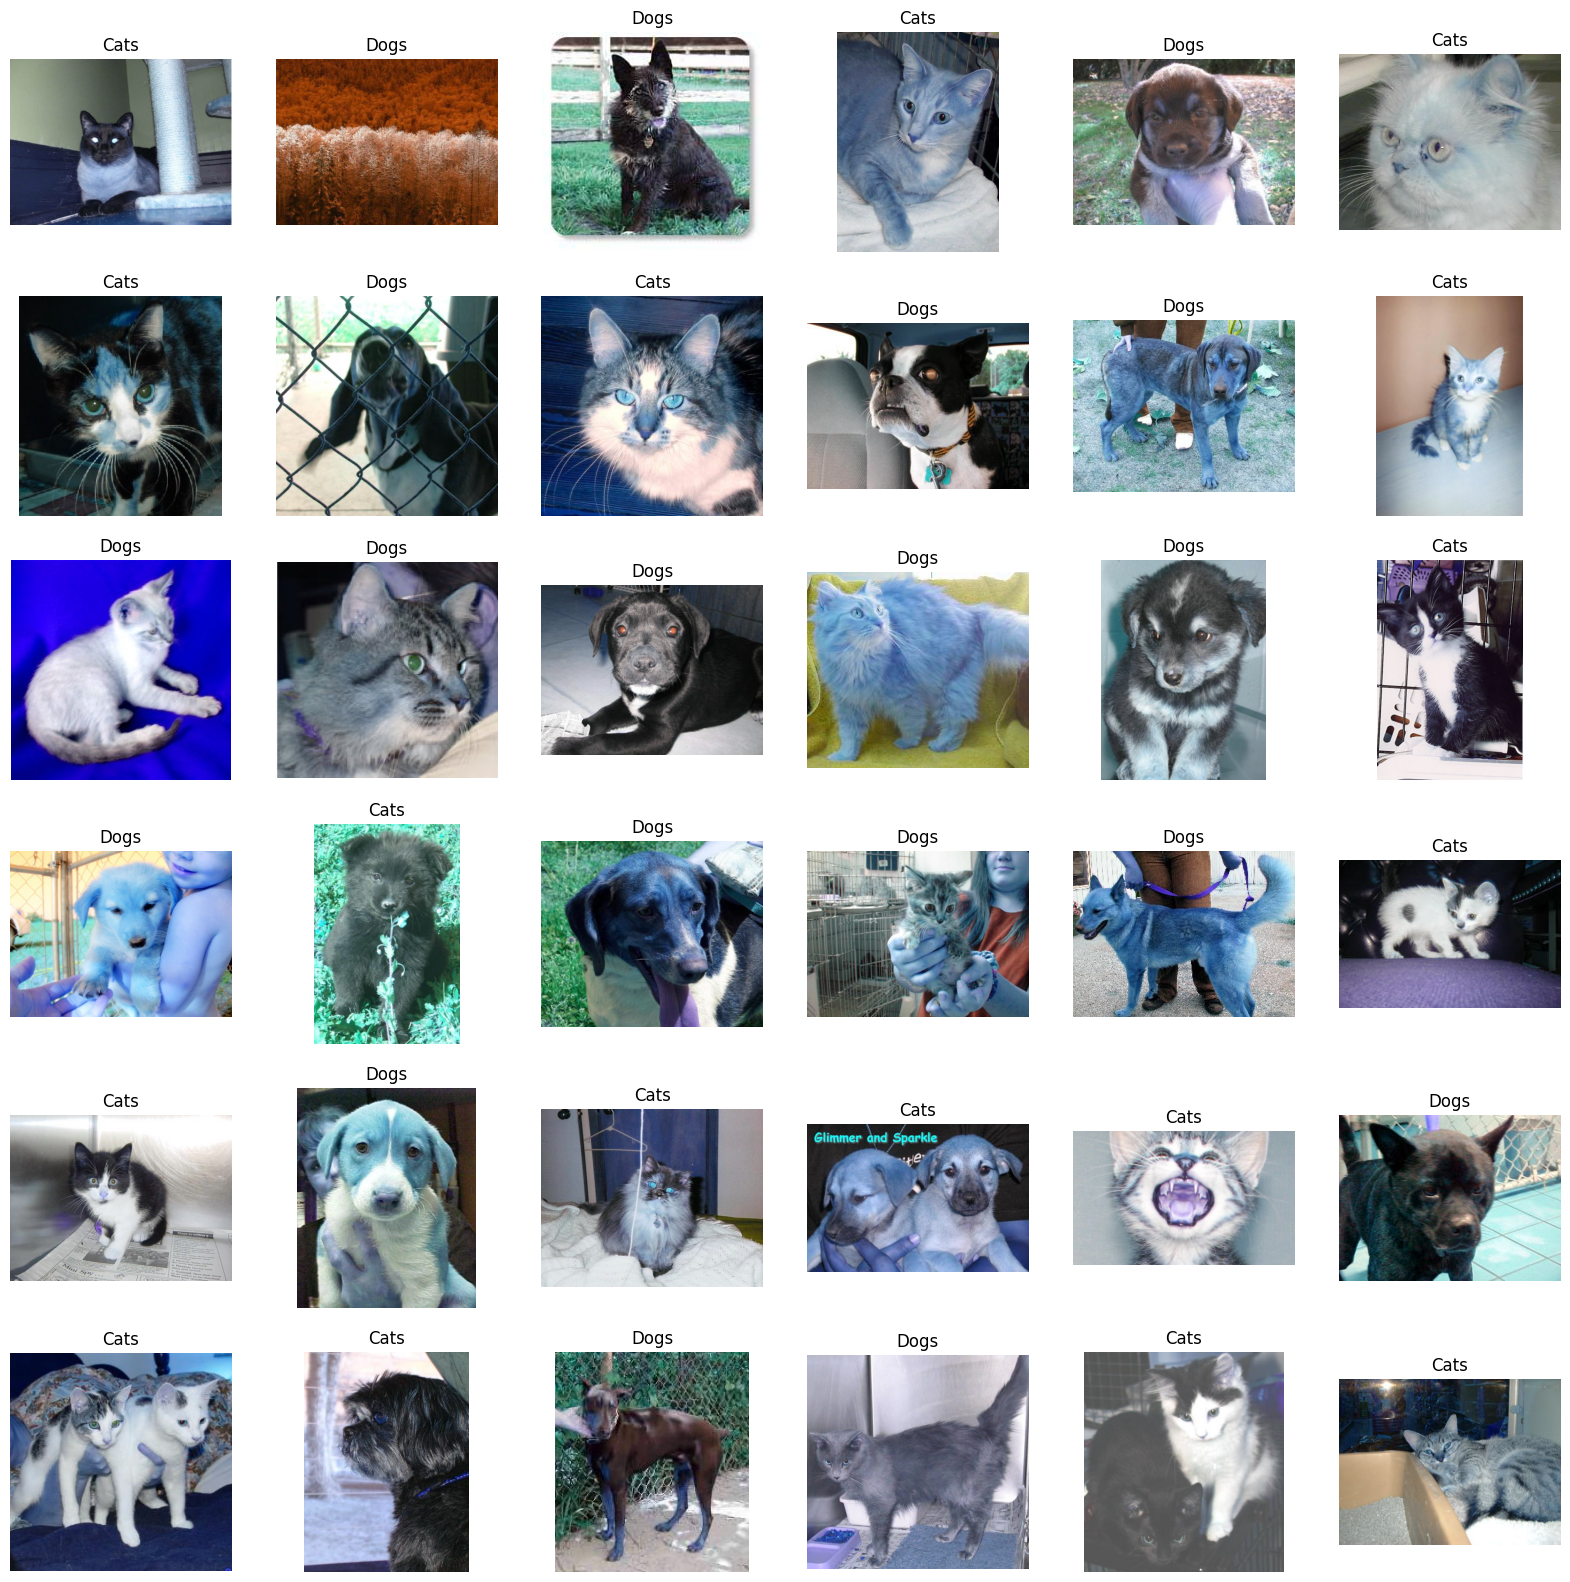

In [23]:
plt.figure(figsize=(20,20))

for n , i in enumerate(list(np.random.randint(0, len(test_data),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(test_data[i])
    plt.axis('off')
    plt.title(class_names[pred_labels[i][0]])